# chatGLM模型代码注释
整体结构如下\
未使用P-tuning时蓝色路线中Prompt Encoder不使用，也就等价于Prefix-tuning，但对模型影响不大
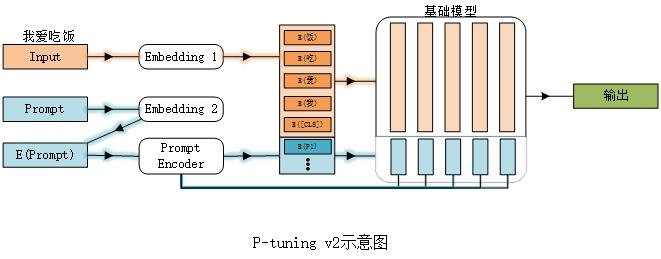

## 需要的包加载

In [ ]:
""" PyTorch ChatGLM model. """

import math
import copy
import warnings
import re
import sys

import torch
import torch.utils.checkpoint
import torch.nn.functional as F
from torch import nn
from torch.nn import CrossEntropyLoss, LayerNorm, MSELoss, BCEWithLogitsLoss
from torch.nn.utils import skip_init
from typing import Optional, Tuple, Union, List, Callable, Dict, Any
from copy import deepcopy

from transformers.modeling_outputs import (
    BaseModelOutputWithPast,
    CausalLMOutputWithPast,
    SequenceClassifierOutputWithPast,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import logging
from transformers.generation.logits_process import LogitsProcessor
from transformers.generation.utils import LogitsProcessorList, StoppingCriteriaList, GenerationConfig, ModelOutput

from .configuration_chatglm import ChatGLMConfig


## 无关紧要的部分

In [ ]:
#Mac系统的初始化\
#不会真有人用苹果跑大模型吧
if sys.platform != 'darwin':
    torch._C._jit_set_profiling_mode(False)
    torch._C._jit_set_profiling_executor(False)
    torch._C._jit_override_can_fuse_on_cpu(True)
    torch._C._jit_override_can_fuse_on_gpu(True)

#用于往日志里加信息
logger = logging.get_logger(__name__)


In [ ]:
#一些全局变量，用于外部调用，没啥用
_CHECKPOINT_FOR_DOC = "THUDM/ChatGLM"
_CONFIG_FOR_DOC = "ChatGLMConfig"

CHATGLM_6B_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "THUDM/chatglm3-6b",
    # See all ChatGLM models at https://huggingface.co/models?filter=chatglm
]
#一个小函数，将参数放入cls函数里执行并返回结果
def default_init(cls, *args, **kwargs):
    return cls(*args, **kwargs)

## Prefix编码器
论文中，这部分网络结构应该不同的下游任务不同的结构，p-tuning中的Prompt Encoder结构


In [ ]:
class PrefixEncoder(torch.nn.Module):
    """
    The torch.nn model to encode the prefix
    Input shape: (batch-size, prefix-length)
    Output shape: (batch-size, prefix-length, 2*layers*hidden)
    """

    def __init__(self, config: ChatGLMConfig):
        super().__init__()
        #默认为False，只有P-tuning后才会改为True
        self.prefix_projection = config.prefix_projection
        if self.prefix_projection:
            # Use a two-layer MLP to encode the prefix
            #num_layers = 28 kv_channels=128 multi_query_group_num=1
            #kv_size=7168
            kv_size = config.num_layers * config.kv_channels * config.multi_query_group_num * 2
            #将token对应的id 通过可学习矩阵嵌入
            #pre_seq_len来自于输入设置，不同的任务应不同
            #字典大小为pre_seq_len，词嵌入维度为kv_size
            self.embedding = torch.nn.Embedding(config.pre_seq_len, kv_size)
            #用了两层MLP对嵌入后的向量进行运算（特征提取）
            self.trans = torch.nn.Sequential(
                torch.nn.Linear(kv_size, config.hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(config.hidden_size, kv_size)
            )
        else:
            #不为真时只相当于prompt？ tuning
            self.embedding = torch.nn.Embedding(config.pre_seq_len,
                                                config.num_layers * config.kv_channels * config.multi_query_group_num * 2)

    def forward(self, prefix: torch.Tensor):
        if self.prefix_projection:
            prefix_tokens = self.embedding(prefix)
            past_key_values = self.trans(prefix_tokens)
        else:
            past_key_values = self.embedding(prefix)
        return past_key_values

## 一个用于将张量在最后一个维度分割的函数

In [ ]:
def split_tensor_along_last_dim(
        tensor: torch.Tensor,
        num_partitions: int,
        contiguous_split_chunks: bool = False,
) -> List[torch.Tensor]:
    """将张量在最后一个维度上分解为num_partitions个

    输入参数:
        tensor: 要分割的张量.
        num_partitions: 要将向量分为多少个
        contiguous_split_chunks: 如果为真会调用contiguous()将变换后的张量，在内存上连续

    Returns:
        返回一个张量列表，列表长度与num_partitions一致，如果不可整除，则最后一个张量会小一些
    """
    #获得总共维度数 减一获得最后一维的位置key（为什么不直接用-1呢）
    last_dim = tensor.dim() - 1
    #获得最后一维的维度大小 再整除分割的份数
    last_dim_size = tensor.size()[last_dim] // num_partitions
    # 将张量在最后一个维度进行分割 如下
    #A.shape=（a,b,c） 
    #B=split(A,3,0)   B=((3,b,c),(3,b,c),···,(3,b,c))  
    tensor_list = torch.split(tensor, last_dim_size, dim=last_dim)
    # Note: torch.split does not create contiguous tensors by default.
    if contiguous_split_chunks:
        #使得变换后的张量，在内存上连续，方便后续使用
        return tuple(chunk.contiguous() for chunk in tensor_list)

    return tensor_list

## 旋转式位置编码
使用了LLaMA模型中也使用的的旋转式位置编码\
能够将相对位置信息依赖集成到 self-attention 中并提升 transformer 架构性能的位置编码方式\
论文名：ROFORMER: ENHANCED TRANSFORMER WITH ROTARYPOSITION EMBEDDING\
作者：深圳追一科技

In [ ]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, original_impl=False, device=None, dtype=None):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2, device=device).to(dtype=dtype) / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.dim = dim
        self.original_impl = original_impl

    def forward_impl(
            self, seq_len: int, n_elem: int, dtype: torch.dtype, device: torch.device, base: int = 10000
    ):
        """Enhanced Transformer with Rotary Position Embedding.

        Derived from: https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/
        transformers/rope/__init__.py. MIT License:
        https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/license.
        """
        # $\Theta = {\theta_i = 10000^{\frac{2(i-1)}{d}}, i \in [1, 2, ..., \frac{d}{2}]}$
        theta = 1.0 / (base ** (torch.arange(0, n_elem, 2, dtype=torch.float, device=device) / n_elem))

        # Create position indexes `[0, 1, ..., seq_len - 1]`
        seq_idx = torch.arange(seq_len, dtype=torch.float, device=device)

        # Calculate the product of position index and $\theta_i$
        idx_theta = torch.outer(seq_idx, theta).float()

        cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)

        # this is to mimic the behaviour of complex32, else we will get different results
        if dtype in (torch.float16, torch.bfloat16, torch.int8):
            cache = cache.bfloat16() if dtype == torch.bfloat16 else cache.half()
        return cache

    def forward(self, max_seq_len, offset=0):
        return self.forward_impl(
            max_seq_len, self.dim, dtype=self.inv_freq.dtype, device=self.inv_freq.device
        )


## 将位置编码以巧妙的方式加入输入中

In [ ]:
#这一部分依然是旋转位置编码的一个函数， 后面再说
#优化语句，非常复杂，总之就会变强
@torch.jit.script
def apply_rotary_pos_emb(x: torch.Tensor, rope_cache: torch.Tensor) -> torch.Tensor:
    # x: [sq, b, np, hn]
    sq, b, np, hn = x.size(0), x.size(1), x.size(2), x.size(3)
    rot_dim = rope_cache.shape[-2] * 2
    x, x_pass = x[..., :rot_dim], x[..., rot_dim:]
    # truncate to support variable sizes
    rope_cache = rope_cache[:sq]
    xshaped = x.reshape(sq, -1, np, rot_dim // 2, 2)
    rope_cache = rope_cache.view(sq, -1, 1, xshaped.size(3), 2)
    x_out2 = torch.stack(
        [
            xshaped[..., 0] * rope_cache[..., 0] - xshaped[..., 1] * rope_cache[..., 1],
            xshaped[..., 1] * rope_cache[..., 0] + xshaped[..., 0] * rope_cache[..., 1],
        ],
        -1,
    )
    x_out2 = x_out2.flatten(3)
    return torch.cat((x_out2, x_pass), dim=-1)

## 归一化
论文：Root Mean Square Layer Normalization \
另一种归一化方法,对层归一化进行了改进，减少了计算代价\
RMSNorm舍弃了中心化操作，归一化过程只实现缩放，缩放系数是均方根(RMS)，L-N的均值 
 为0时便是RMSNorm，RMS所做的只是缩放，不会改变数据原本的分布，有利于激活函数输出的稳定（缩放不改变向量方向）：

In [ ]:
class RMSNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5, device=None, dtype=None, **kwargs):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.empty(normalized_shape, device=device, dtype=dtype))
        self.eps = eps

    def forward(self, hidden_states: torch.Tensor):
        input_dtype = hidden_states.dtype
        variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.eps)

        return (self.weight * hidden_states).to(input_dtype)


## 注意力部分
chatGLM使用了多队列注意力（multi_query_attention）\
每个头都会产生自己的Q值，但是K,V是所有头共用的
与多头注意力机制区别如下\
继承自chatGLM2
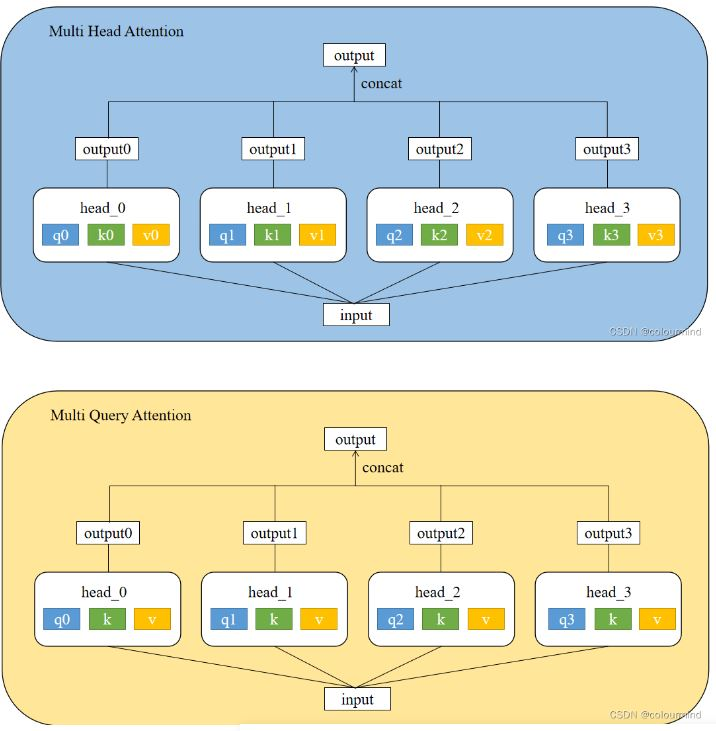


In [ ]:
#简单封装Attention
class CoreAttention(torch.nn.Module):
    def __init__(self, config: ChatGLMConfig, layer_number):
        #这部分只是进行了一些参数初始化
        super(CoreAttention, self).__init__()
        #apply_query_key_layer_scaling=True
        self.apply_query_key_layer_scaling = config.apply_query_key_layer_scaling
        #attention_softmax_in_fp32=True
        self.attention_softmax_in_fp32 = config.attention_softmax_in_fp32
        if self.apply_query_key_layer_scaling:
            self.attention_softmax_in_fp32 = True
        #
        self.layer_number = max(1, layer_number)
        #kv_channels=128   num_attention_heads=32
        #projection_size = 4096
        projection_size = config.kv_channels * config.num_attention_heads

        # Per attention head and per partition values.
        self.hidden_size_per_partition = projection_size
        #hidden_size_per_attention_head=128
        self.hidden_size_per_attention_head = projection_size // config.num_attention_heads
        #num_attention_heads_per_partition=32
        self.num_attention_heads_per_partition = config.num_attention_heads

        coeff = None
        #正则化因子 √128 
        self.norm_factor = math.sqrt(self.hidden_size_per_attention_head)
        if self.apply_query_key_layer_scaling:
            coeff = self.layer_number
            self.norm_factor *= coeff
        #coeff = 层数
        self.coeff = coeff
        #attention_dropout=0.0
        self.attention_dropout = torch.nn.Dropout(config.attention_dropout)

    def forward(self, query_layer, key_layer, value_layer, attention_mask):
        #对pytorch主版本进行区分，不同版本不同代码
        pytorch_major_version = int(torch.__version__.split('.')[0])
        if pytorch_major_version >= 2:
            #pytorch2代码
            #QKV的维度顺序调整将第一个维度放到第三个位置
            query_layer, key_layer, value_layer = [k.permute(1, 2, 0, 3) for k in [query_layer, key_layer, value_layer]]
            #如果有mask且Q第三维度也就是原第一维度与K第三维度也就是原第一维度 大小一致则
            if attention_mask is None and query_layer.shape[2] == key_layer.shape[2]:
                #CausalAttention 必须有mask,没有报错
                context_layer = torch.nn.functional.scaled_dot_product_attention(query_layer, key_layer, value_layer,
                                                                                 is_causal=True)
            else:
                if attention_mask is not None:
                    #取反
                    attention_mask = ~attention_mask
                #点积注意力
                context_layer = torch.nn.functional.scaled_dot_product_attention(query_layer, key_layer, value_layer,
                                                                                 attention_mask)
            #将改变的维度顺序换回
            context_layer = context_layer.permute(2, 0, 1, 3)
            new_context_layer_shape = context_layer.size()[:-2] + (self.hidden_size_per_partition,)
            #将元组中的数值按顺序传入reshape函数
            context_layer = context_layer.reshape(*new_context_layer_shape)
        else:
            # Raw attention scores

            # [b, np, sq, sk]
            output_size = (query_layer.size(1), query_layer.size(2), query_layer.size(0), key_layer.size(0))

            # [sq, b, np, hn] -> [sq, b * np, hn]
            query_layer = query_layer.view(output_size[2], output_size[0] * output_size[1], -1)
            # [sk, b, np, hn] -> [sk, b * np, hn]
            key_layer = key_layer.view(output_size[3], output_size[0] * output_size[1], -1)

            # preallocting input tensor: [b * np, sq, sk]
            matmul_input_buffer = torch.empty(
                output_size[0] * output_size[1], output_size[2], output_size[3], dtype=query_layer.dtype,
                device=query_layer.device
            )

            # Raw attention scores. [b * np, sq, sk]
            matmul_result = torch.baddbmm(
                matmul_input_buffer,
                query_layer.transpose(0, 1),  # [b * np, sq, hn]
                key_layer.transpose(0, 1).transpose(1, 2),  # [b * np, hn, sk]
                beta=0.0,
                alpha=(1.0 / self.norm_factor),
            )

            # change view to [b, np, sq, sk]
            attention_scores = matmul_result.view(*output_size)

            # ===========================
            # Attention probs and dropout
            # ===========================

            # attention scores and attention mask [b, np, sq, sk]
            if self.attention_softmax_in_fp32:
                attention_scores = attention_scores.float()
            if self.coeff is not None:
                attention_scores = attention_scores * self.coeff
            if attention_mask is None and attention_scores.shape[2] == attention_scores.shape[3]:
                attention_mask = torch.ones(output_size[0], 1, output_size[2], output_size[3],
                                            device=attention_scores.device, dtype=torch.bool)
                attention_mask.tril_()
                attention_mask = ~attention_mask
            if attention_mask is not None:
                attention_scores = attention_scores.masked_fill(attention_mask, float("-inf"))
            attention_probs = F.softmax(attention_scores, dim=-1)
            attention_probs = attention_probs.type_as(value_layer)

            # This is actually dropping out entire tokens to attend to, which might
            # seem a bit unusual, but is taken from the original Transformer paper.
            attention_probs = self.attention_dropout(attention_probs)
            # =========================
            # Context layer. [sq, b, hp]
            # =========================

            # value_layer -> context layer.
            # [sk, b, np, hn] --> [b, np, sq, hn]

            # context layer shape: [b, np, sq, hn]
            output_size = (value_layer.size(1), value_layer.size(2), query_layer.size(0), value_layer.size(3))
            # change view [sk, b * np, hn]
            value_layer = value_layer.view(value_layer.size(0), output_size[0] * output_size[1], -1)
            # change view [b * np, sq, sk]
            attention_probs = attention_probs.view(output_size[0] * output_size[1], output_size[2], -1)
            # matmul: [b * np, sq, hn]
            context_layer = torch.bmm(attention_probs, value_layer.transpose(0, 1))
            # change view [b, np, sq, hn]
            context_layer = context_layer.view(*output_size)
            # [b, np, sq, hn] --> [sq, b, np, hn]
            context_layer = context_layer.permute(2, 0, 1, 3).contiguous()
            # [sq, b, np, hn] --> [sq, b, hp]
            new_context_layer_shape = context_layer.size()[:-2] + (self.hidden_size_per_partition,)
            context_layer = context_layer.view(*new_context_layer_shape)

        return context_layer




In [ ]:
class SelfAttention(torch.nn.Module):
    """Parallel self-attention layer abstract class.

    Self-attention layer takes input with size [s, b, h]
    and returns output of the same size.
    """

    def __init__(self, config: ChatGLMConfig, layer_number, device=None):
        super(SelfAttention, self).__init__()
        self.layer_number = max(1, layer_number)

        self.projection_size = config.kv_channels * config.num_attention_heads

        # Per attention head and per partition values.
        self.hidden_size_per_attention_head = self.projection_size // config.num_attention_heads
        self.num_attention_heads_per_partition = config.num_attention_heads

        self.multi_query_attention = config.multi_query_attention
        self.qkv_hidden_size = 3 * self.projection_size
        if self.multi_query_attention:
            self.num_multi_query_groups_per_partition = config.multi_query_group_num
            self.qkv_hidden_size = (
                    self.projection_size + 2 * self.hidden_size_per_attention_head * config.multi_query_group_num
            )
        self.query_key_value = nn.Linear(config.hidden_size, self.qkv_hidden_size,
                                         bias=config.add_bias_linear or config.add_qkv_bias,
                                         device=device, **_config_to_kwargs(config)
                                         )

        self.core_attention = CoreAttention(config, self.layer_number)

        # **_config_to_kwargs(config)默认情况下是设施dtype=None
        self.dense = nn.Linear(self.projection_size, config.hidden_size, bias=config.add_bias_linear,
                               device=device, **_config_to_kwargs(config)
                               )

    def _allocate_memory(self, inference_max_sequence_len, batch_size, device=None, dtype=None):
        if self.multi_query_attention:
            num_attention_heads = self.num_multi_query_groups_per_partition
        else:
            num_attention_heads = self.num_attention_heads_per_partition
        return torch.empty(
            inference_max_sequence_len,
            batch_size,
            num_attention_heads,
            self.hidden_size_per_attention_head,
            dtype=dtype,
            device=device,
        )

    def forward(
            self, hidden_states, attention_mask, rotary_pos_emb, kv_cache=None, use_cache=True
    ):
        # hidden_states: [sq, b, h]

        # =================================================
        # Pre-allocate memory for key-values for inference.
        # =================================================
        # =====================
        # Query, Key, and Value
        # =====================

        # Attention heads [sq, b, h] --> [sq, b, (np * 3 * hn)]
        mixed_x_layer = self.query_key_value(hidden_states)

        if self.multi_query_attention:
            (query_layer, key_layer, value_layer) = mixed_x_layer.split(
                [
                    self.num_attention_heads_per_partition * self.hidden_size_per_attention_head,
                    self.num_multi_query_groups_per_partition * self.hidden_size_per_attention_head,
                    self.num_multi_query_groups_per_partition * self.hidden_size_per_attention_head,
                ],
                dim=-1,
            )
            query_layer = query_layer.view(
                query_layer.size()[:-1] + (self.num_attention_heads_per_partition, self.hidden_size_per_attention_head)
            )
            key_layer = key_layer.view(
                key_layer.size()[:-1] + (self.num_multi_query_groups_per_partition, self.hidden_size_per_attention_head)
            )
            value_layer = value_layer.view(
                value_layer.size()[:-1]
                + (self.num_multi_query_groups_per_partition, self.hidden_size_per_attention_head)
            )
        else:
            new_tensor_shape = mixed_x_layer.size()[:-1] + \
                               (self.num_attention_heads_per_partition,
                                3 * self.hidden_size_per_attention_head)
            mixed_x_layer = mixed_x_layer.view(*new_tensor_shape)

            # [sq, b, np, 3 * hn] --> 3 [sq, b, np, hn]
            (query_layer, key_layer, value_layer) = split_tensor_along_last_dim(mixed_x_layer, 3)

        # apply relative positional encoding (rotary embedding)
        if rotary_pos_emb is not None:
            query_layer = apply_rotary_pos_emb(query_layer, rotary_pos_emb)
            key_layer = apply_rotary_pos_emb(key_layer, rotary_pos_emb)

        # adjust key and value for inference
        if kv_cache is not None:
            cache_k, cache_v = kv_cache
            key_layer = torch.cat((cache_k, key_layer), dim=0)
            value_layer = torch.cat((cache_v, value_layer), dim=0)
        if use_cache:
            kv_cache = (key_layer, value_layer)
        else:
            kv_cache = None

        if self.multi_query_attention:
            key_layer = key_layer.unsqueeze(-2)
            key_layer = key_layer.expand(
                -1, -1, -1, self.num_attention_heads_per_partition // self.num_multi_query_groups_per_partition, -1
            )
            key_layer = key_layer.contiguous().view(
                key_layer.size()[:2] + (self.num_attention_heads_per_partition, self.hidden_size_per_attention_head)
            )
            value_layer = value_layer.unsqueeze(-2)
            value_layer = value_layer.expand(
                -1, -1, -1, self.num_attention_heads_per_partition // self.num_multi_query_groups_per_partition, -1
            )
            value_layer = value_layer.contiguous().view(
                value_layer.size()[:2] + (self.num_attention_heads_per_partition, self.hidden_size_per_attention_head)
            )

        # ==================================
        # core attention computation
        # ==================================

        context_layer = self.core_attention(query_layer, key_layer, value_layer, attention_mask)

        # =================
        # Output. [sq, b, h]
        # =================

        output = self.dense(context_layer)

        return output, kv_cache


## 全连接层
多个全连接层会将维度扩展为四倍原始维度，再压缩回原来的维度
    中间使用了silu激活函数，y=x*sigmod(x),零点附近更加平滑，缺点需要更多的Norm操作

In [ ]:
class MLP(torch.nn.Module):
    """MLP.

    多个全连接层会将维度扩展为四倍原始维度，再压缩回原来的维度
    中间使用了silu激活函数，y=x*sigmod(x),零点附近更加平滑，缺点需要更多的Norm操作
    """

    def __init__(self, config: ChatGLMConfig, device=None):
        super(MLP, self).__init__()

        self.add_bias = config.add_bias_linear

        # Project to 4h. If using swiglu double the output width, see https://arxiv.org/pdf/2002.05202.pdf
        self.dense_h_to_4h = nn.Linear(
            config.hidden_size,
            config.ffn_hidden_size * 2,
            bias=self.add_bias,
            device=device,
            **_config_to_kwargs(config)
        )

        def swiglu(x):
            x = torch.chunk(x, 2, dim=-1)
            return F.silu(x[0]) * x[1]

        self.activation_func = swiglu

        # Project back to h.
        self.dense_4h_to_h = nn.Linear(
            config.ffn_hidden_size,
            config.hidden_size,
            bias=self.add_bias,
            device=device,
            **_config_to_kwargs(config)
        )

    def forward(self, hidden_states):
        # [s, b, 4hp]
        intermediate_parallel = self.dense_h_to_4h(hidden_states)
        intermediate_parallel = self.activation_func(intermediate_parallel)
        # [s, b, h]
        output = self.dense_4h_to_h(intermediate_parallel)
        return output

## GLMBlock
chatGLM基础模块 结构图如下\
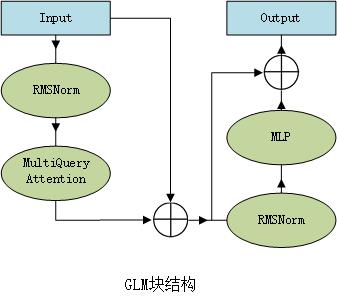

In [ ]:
class GLMBlock(torch.nn.Module):
    """A single transformer layer.

    Transformer layer takes input with size [s, b, h] and returns an
    output of the same size.
    """

    def __init__(self, config: ChatGLMConfig, layer_number, device=None):
        super(GLMBlock, self).__init__()
        #layer_number=28
        self.layer_number = layer_number
        #apply_residual_connection_post_layernorm=False
        self.apply_residual_connection_post_layernorm = config.apply_residual_connection_post_layernorm
        #fp32_residual_connection = False
        self.fp32_residual_connection = config.fp32_residual_connection
        #LayerNormFunc
        LayerNormFunc = RMSNorm if config.rmsnorm else LayerNorm
        # Layernorm on the input data.
        self.input_layernorm = LayerNormFunc(config.hidden_size, eps=config.layernorm_epsilon, device=device,
                                             dtype=config.torch_dtype)

        # Self attention.
        self.self_attention = SelfAttention(config, layer_number, device=device)
        self.hidden_dropout = config.hidden_dropout

        # Layernorm on the attention output
        self.post_attention_layernorm = LayerNormFunc(config.hidden_size, eps=config.layernorm_epsilon, device=device,
                                                      dtype=config.torch_dtype)

        # MLP
        self.mlp = MLP(config, device=device)

    def forward(
            self, hidden_states, attention_mask, rotary_pos_emb, kv_cache=None, use_cache=True,
    ):
        # hidden_states: [s, b, h]

        # Layer norm at the beginning of the transformer layer.
        layernorm_output = self.input_layernorm(hidden_states)
        # Self attention.
        attention_output, kv_cache = self.self_attention(
            layernorm_output,
            attention_mask,
            rotary_pos_emb,
            kv_cache=kv_cache,
            use_cache=use_cache
        )

        # Residual connection.
        if self.apply_residual_connection_post_layernorm:
            residual = layernorm_output
        else:
            residual = hidden_states

        layernorm_input = torch.nn.functional.dropout(attention_output, p=self.hidden_dropout, training=self.training)
        layernorm_input = residual + layernorm_input

        # Layer norm post the self attention.
        layernorm_output = self.post_attention_layernorm(layernorm_input)

        # MLP.
        mlp_output = self.mlp(layernorm_output)

        # Second residual connection.
        if self.apply_residual_connection_post_layernorm:
            residual = layernorm_output
        else:
            residual = layernorm_input

        output = torch.nn.functional.dropout(mlp_output, p=self.hidden_dropout, training=self.training)
        output = residual + output

        return output, kv_cache


## chatGLM主体模型部分
由28个GLM模块，最后再经过一次RMS层归一化，得到输出

In [ ]:
class GLMTransformer(torch.nn.Module):
    """Transformer class."""

    def __init__(self, config: ChatGLMConfig, device=None):
        super(GLMTransformer, self).__init__()
        #fp32_residual_connection=False
        self.fp32_residual_connection = config.fp32_residual_connection
        #post_layer_norm=True
        self.post_layer_norm = config.post_layer_norm

        # num_layers=28
        self.num_layers = config.num_layers

        # Transformer layers.
        def build_layer(layer_number):
            return GLMBlock(config, layer_number, device=device)
        #堆叠28个GLM块
        self.layers = torch.nn.ModuleList([build_layer(i + 1) for i in range(self.num_layers)])

        if self.post_layer_norm:
            #RMSNorm
            LayerNormFunc = RMSNorm if config.rmsnorm else LayerNorm
            # Final layer norm before output.
            self.final_layernorm = LayerNormFunc(config.hidden_size, eps=config.layernorm_epsilon, device=device,
                                                 dtype=config.torch_dtype)

        self.gradient_checkpointing = False
    #获得第几层的GLM模块
    def _get_layer(self, layer_number):
        return self.layers[layer_number]

    def forward(
            self, hidden_states, attention_mask, rotary_pos_emb, kv_caches=None,
            use_cache: Optional[bool] = True,
            output_hidden_states: Optional[bool] = False,
    ):
        """
        如果需要返回所有模块输出，则output_hidden_states设置为True，默认为False
        如果需要训练时保存每次训练的checkpoint 则在初始化模块时self.gradient_checkpointing设为True
        如果设置kv_caches会返回每个注意力中的KV的值
        """
        if not kv_caches:
            kv_caches = [None for _ in range(self.num_layers)]
        presents = () if use_cache else None
        #
        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        all_self_attentions = None
        all_hidden_states = () if output_hidden_states else None
        for index in range(self.num_layers):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer = self._get_layer(index)
            if self.gradient_checkpointing and self.training:
                layer_ret = torch.utils.checkpoint.checkpoint(
                    layer,
                    hidden_states,
                    attention_mask,
                    rotary_pos_emb,
                    kv_caches[index],
                    use_cache
                )
            else:
                layer_ret = layer(
                    hidden_states,
                    attention_mask,
                    rotary_pos_emb,
                    kv_cache=kv_caches[index],
                    use_cache=use_cache
                )
            hidden_states, kv_cache = layer_ret
            if use_cache:
                presents = presents + (kv_cache,)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        # Final layer norm.
        if self.post_layer_norm:
            hidden_states = self.final_layernorm(hidden_states)

        return hidden_states, presents, all_hidden_states, all_self_attentions



## 继承Hugging Face的基础类
要想将模型上传Hugging Face,就必须继承这个类\
transformers.modeling_utils.PreTrainedModel

In [ ]:
class ChatGLMPreTrainedModel(PreTrainedModel):
    """
    一个抽象类，用于处理权重初始化，和一些简单的工具函数
    """

    is_parallelizable = False
    supports_gradient_checkpointing = True
    config_class = ChatGLMConfig
    base_model_prefix = "transformer"
    _no_split_modules = ["GLMBlock"]

    def _init_weights(self, module: nn.Module):
        """Initialize the weights."""
        return

    def get_masks(self, input_ids, past_key_values, padding_mask=None):
        batch_size, seq_length = input_ids.shape
        full_attention_mask = torch.ones(batch_size, seq_length, seq_length, device=input_ids.device)
        full_attention_mask.tril_()
        past_length = 0
        if past_key_values:
            past_length = past_key_values[0][0].shape[0]
        if past_length:
            full_attention_mask = torch.cat((torch.ones(batch_size, seq_length, past_length,
                                                        device=input_ids.device), full_attention_mask), dim=-1)
        if padding_mask is not None:
            full_attention_mask = full_attention_mask * padding_mask.unsqueeze(1)
        if not past_length and padding_mask is not None:
            full_attention_mask -= padding_mask.unsqueeze(-1) - 1
        full_attention_mask = (full_attention_mask < 0.5).bool()
        full_attention_mask.unsqueeze_(1)
        return full_attention_mask

    def get_position_ids(self, input_ids, device):
        batch_size, seq_length = input_ids.shape
        position_ids = torch.arange(seq_length, dtype=torch.long, device=device).unsqueeze(0).repeat(batch_size, 1)
        return position_ids

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, GLMTransformer):
            module.gradient_checkpointing = value


## Embedding层
输入的Embedding层，不是Prefix or P-tuning的Embedding

In [ ]:
class Embedding(torch.nn.Module):
    """Language model embeddings."""

    def __init__(self, config: ChatGLMConfig, device=None):
        super(Embedding, self).__init__()

        self.hidden_size = config.hidden_size
        # Word embeddings (parallel).
        self.word_embeddings = nn.Embedding(
            config.padded_vocab_size,
            self.hidden_size,
            dtype=config.torch_dtype,
            device=device
        )
        self.fp32_residual_connection = config.fp32_residual_connection

    def forward(self, input_ids):
        # Embeddings.
        words_embeddings = self.word_embeddings(input_ids)
        embeddings = words_embeddings
        # Data format change to avoid explicit tranposes : [b s h] --> [s b h].
        embeddings = embeddings.transpose(0, 1).contiguous()
        # If the input flag for fp32 residual connection is set, convert for float.
        if self.fp32_residual_connection:
            embeddings = embeddings.float()
        return embeddings


## 真正的chatGLM类
里面东西非常多，只看chat方法和fowrard方法就好，因为太多了


In [ ]:
class ChatGLMForConditionalGeneration(ChatGLMPreTrainedModel):
    def __init__(self, config: ChatGLMConfig, empty_init=True, device=None):
        super().__init__(config)

        self.max_sequence_length = config.max_length
        self.transformer = ChatGLMModel(config, empty_init=empty_init, device=device)
        self.config = config
        self.quantized = False

        if self.config.quantization_bit:
            self.quantize(self.config.quantization_bit, empty_init=True)

    def _update_model_kwargs_for_generation(
            self,
            outputs: ModelOutput,
            model_kwargs: Dict[str, Any],
            is_encoder_decoder: bool = False,
            standardize_cache_format: bool = False,
    ) -> Dict[str, Any]:
        # update past_key_values
        model_kwargs["past_key_values"] = self._extract_past_from_model_output(
            outputs, standardize_cache_format=standardize_cache_format
        )

        # update attention mask
        if "attention_mask" in model_kwargs:
            attention_mask = model_kwargs["attention_mask"]
            model_kwargs["attention_mask"] = torch.cat(
                [attention_mask, attention_mask.new_ones((attention_mask.shape[0], 1))], dim=-1
            )

        # update position ids
        if "position_ids" in model_kwargs:
            position_ids = model_kwargs["position_ids"]
            new_position_id = position_ids[..., -1:].clone()
            new_position_id += 1
            model_kwargs["position_ids"] = torch.cat(
                [position_ids, new_position_id], dim=-1
            )

        model_kwargs["is_first_forward"] = False
        return model_kwargs

    def prepare_inputs_for_generation(
            self,
            input_ids: torch.LongTensor,
            past_key_values: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.Tensor] = None,
            use_cache: Optional[bool] = None,
            is_first_forward: bool = True,
            **kwargs
    ) -> dict:
        # only last token for input_ids if past is not None
        if position_ids is None:
            position_ids = self.get_position_ids(input_ids, device=input_ids.device)
        if not is_first_forward:
            if past_key_values is not None:
                position_ids = position_ids[..., -1:]
                input_ids = input_ids[:, -1:]
        return {
            "input_ids": input_ids,
            "past_key_values": past_key_values,
            "position_ids": position_ids,
            "attention_mask": attention_mask,
            "return_last_logit": True,
            "use_cache": use_cache
        }

    def forward(
            self,
            input_ids: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            past_key_values: Optional[Tuple[torch.FloatTensor]] = None,
            inputs_embeds: Optional[torch.Tensor] = None,
            labels: Optional[torch.Tensor] = None,
            use_cache: Optional[bool] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
            return_last_logit: Optional[bool] = False,
    ):
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids=input_ids,
            position_ids=position_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = transformer_outputs[0]
        if return_last_logit:
            hidden_states = hidden_states[-1:]
        lm_logits = self.transformer.output_layer(hidden_states)
        lm_logits = lm_logits.transpose(0, 1).contiguous()

        loss = None
        if labels is not None:
            lm_logits = lm_logits.to(torch.float32)

            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            lm_logits = lm_logits.to(hidden_states.dtype)
            loss = loss.to(hidden_states.dtype)

        if not return_dict:
            output = (lm_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return CausalLMOutputWithPast(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

    @staticmethod
    def _reorder_cache(
            past: Tuple[Tuple[torch.Tensor, torch.Tensor], ...], beam_idx: torch.LongTensor
    ) -> Tuple[Tuple[torch.Tensor, torch.Tensor], ...]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called. This is required to match `past_key_values` with the correct
        beam_idx at every generation step.

        Output shares the same memory storage as `past`.
        """
        return tuple(
            (
                layer_past[0].index_select(1, beam_idx.to(layer_past[0].device)),
                layer_past[1].index_select(1, beam_idx.to(layer_past[1].device)),
            )
            for layer_past in past
        )

    def process_response(self, output, history):
        content = ""
        history = deepcopy(history)
        for response in output.split("<|assistant|>"):
            metadata, content = response.split("\n", maxsplit=1)
            if not metadata.strip():
                content = content.strip()
                history.append({"role": "assistant", "metadata": metadata, "content": content})
                content = content.replace("[[训练时间]]", "2023年")
            else:
                history.append({"role": "assistant", "metadata": metadata, "content": content})
                if history[0]["role"] == "system" and "tools" in history[0]:
                    content = "\n".join(content.split("\n")[1:-1])
                    def tool_call(**kwargs):
                        return kwargs
                    parameters = eval(content)
                    content = {"name": metadata.strip(), "parameters": parameters}
                else:
                    content = {"name": metadata.strip(), "content": content}
        return content, history

    @torch.inference_mode()
    def chat(self, tokenizer, query: str, history: List[Tuple[str, str]] = None, role: str = "user",
             max_length: int = 8192, num_beams=1, do_sample=True, top_p=0.8, temperature=0.8, logits_processor=None,
             **kwargs):
        if history is None:
            history = []
        if logits_processor is None:
            logits_processor = LogitsProcessorList()
        logits_processor.append(InvalidScoreLogitsProcessor())
        gen_kwargs = {"max_length": max_length, "num_beams": num_beams, "do_sample": do_sample, "top_p": top_p,
                      "temperature": temperature, "logits_processor": logits_processor, **kwargs}
        inputs = tokenizer.build_chat_input(query, history=history, role=role)
        inputs = inputs.to(self.device)
        eos_token_id = [tokenizer.eos_token_id, tokenizer.get_command("<|user|>"),
                        tokenizer.get_command("<|observation|>")]
        outputs = self.generate(**inputs, **gen_kwargs, eos_token_id=eos_token_id)
        outputs = outputs.tolist()[0][len(inputs["input_ids"][0]):-1]
        response = tokenizer.decode(outputs)
        history.append({"role": role, "content": query})
        response, history = self.process_response(response, history)
        return response, history

    @torch.inference_mode()
    def stream_chat(self, tokenizer, query: str, history: List[Tuple[str, str]] = None, role: str = "user",
                    past_key_values=None,max_length: int = 8192, do_sample=True, top_p=0.8, temperature=0.8,
                    logits_processor=None, return_past_key_values=False, **kwargs):
        if history is None:
            history = []
        if logits_processor is None:
            logits_processor = LogitsProcessorList()
        logits_processor.append(InvalidScoreLogitsProcessor())
        eos_token_id = [tokenizer.eos_token_id, tokenizer.get_command("<|user|>"),
                        tokenizer.get_command("<|observation|>")]
        gen_kwargs = {"max_length": max_length, "do_sample": do_sample, "top_p": top_p,
                      "temperature": temperature, "logits_processor": logits_processor, **kwargs}
        if past_key_values is None:
            inputs = tokenizer.build_chat_input(query, history=history, role=role)
        else:
            inputs = tokenizer.build_chat_input(query, role=role)
        inputs = inputs.to(self.device)
        if past_key_values is not None:
            past_length = past_key_values[0][0].shape[0]
            if self.transformer.pre_seq_len is not None:
                past_length -= self.transformer.pre_seq_len
            inputs.position_ids += past_length
            attention_mask = inputs.attention_mask
            attention_mask = torch.cat((attention_mask.new_ones(1, past_length), attention_mask), dim=1)
            inputs['attention_mask'] = attention_mask
        history.append({"role": role, "content": query})
        for outputs in self.stream_generate(**inputs, past_key_values=past_key_values,
                                            eos_token_id=eos_token_id, return_past_key_values=return_past_key_values,
                                            **gen_kwargs):
            if return_past_key_values:
                outputs, past_key_values = outputs
            outputs = outputs.tolist()[0][len(inputs["input_ids"][0]):-1]
            response = tokenizer.decode(outputs)
            if response and response[-1] != "�":
                response, new_history = self.process_response(response, history)
                if return_past_key_values:
                    yield response, new_history, past_key_values
                else:
                    yield response, new_history

    @torch.inference_mode()
    def stream_generate(
            self,
            input_ids,
            generation_config: Optional[GenerationConfig] = None,
            logits_processor: Optional[LogitsProcessorList] = None,
            stopping_criteria: Optional[StoppingCriteriaList] = None,
            prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None,
            return_past_key_values=False,
            **kwargs,
    ):
        batch_size, input_ids_seq_length = input_ids.shape[0], input_ids.shape[-1]

        if generation_config is None:
            generation_config = self.generation_config
        generation_config = copy.deepcopy(generation_config)
        model_kwargs = generation_config.update(**kwargs)
        model_kwargs["use_cache"] = generation_config.use_cache
        bos_token_id, eos_token_id = generation_config.bos_token_id, generation_config.eos_token_id

        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        has_default_max_length = kwargs.get("max_length") is None and generation_config.max_length is not None
        if has_default_max_length and generation_config.max_new_tokens is None:
            warnings.warn(
                f"Using `max_length`'s default ({generation_config.max_length}) to control the generation length. "
                "This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we"
                " recommend using `max_new_tokens` to control the maximum length of the generation.",
                UserWarning,
            )
        elif generation_config.max_new_tokens is not None:
            generation_config.max_length = generation_config.max_new_tokens + input_ids_seq_length
            if not has_default_max_length:
                logger.warn(
                    f"Both `max_new_tokens` (={generation_config.max_new_tokens}) and `max_length`(="
                    f"{generation_config.max_length}) seem to have been set. `max_new_tokens` will take precedence. "
                    "Please refer to the documentation for more information. "
                    "(https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)",
                    UserWarning,
                )

        if input_ids_seq_length >= generation_config.max_length:
            input_ids_string = "decoder_input_ids" if self.config.is_encoder_decoder else "input_ids"
            logger.warning(
                f"Input length of {input_ids_string} is {input_ids_seq_length}, but `max_length` is set to"
                f" {generation_config.max_length}. This can lead to unexpected behavior. You should consider"
                " increasing `max_new_tokens`."
            )

        # 2. Set generation parameters if not already defined
        logits_processor = logits_processor if logits_processor is not None else LogitsProcessorList()
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()

        logits_processor = self._get_logits_processor(
            generation_config=generation_config,
            input_ids_seq_length=input_ids_seq_length,
            encoder_input_ids=input_ids,
            prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
            logits_processor=logits_processor,
        )

        stopping_criteria = self._get_stopping_criteria(
            generation_config=generation_config, stopping_criteria=stopping_criteria
        )
        logits_warper = self._get_logits_warper(generation_config)

        unfinished_sequences = input_ids.new(input_ids.shape[0]).fill_(1)
        scores = None
        while True:
            model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)
            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=False,
                output_hidden_states=False,
            )

            next_token_logits = outputs.logits[:, -1, :]

            # pre-process distribution
            next_token_scores = logits_processor(input_ids, next_token_logits)
            next_token_scores = logits_warper(input_ids, next_token_scores)

            # sample
            probs = nn.functional.softmax(next_token_scores, dim=-1)
            if generation_config.do_sample:
                next_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)
            else:
                next_tokens = torch.argmax(probs, dim=-1)
            # update generated ids, model inputs, and length for next step
            input_ids = torch.cat([input_ids, next_tokens[:, None]], dim=-1)
            model_kwargs = self._update_model_kwargs_for_generation(
                outputs, model_kwargs, is_encoder_decoder=self.config.is_encoder_decoder
            )
            unfinished_sequences = unfinished_sequences.mul(
                next_tokens.tile(eos_token_id_tensor.shape[0], 1).ne(eos_token_id_tensor.unsqueeze(1)).prod(dim=0)
            )
            if return_past_key_values:
                yield input_ids, outputs.past_key_values
            else:
                yield input_ids
            # stop when each sentence is finished, or if we exceed the maximum length
            if unfinished_sequences.max() == 0 or stopping_criteria(input_ids, scores):
                break

    def quantize(self, bits: int, empty_init=False, device=None, **kwargs):
        if bits == 0:
            return

        from .quantization import quantize

        if self.quantized:
            logger.info("Already quantized.")
            return self

        self.quantized = True

        self.config.quantization_bit = bits

        self.transformer.encoder = quantize(self.transformer.encoder, bits, empty_init=empty_init, device=device,
                                            **kwargs)
        return self

